In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer

from scipy.stats import describe, rankdata, mannwhitneyu

from tqdm import tqdm_notebook

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [29]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

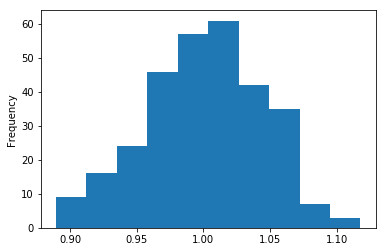

In [11]:
train[train.columns[2:]].std().plot('hist');

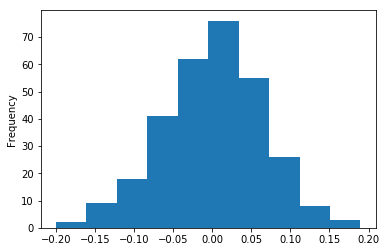

In [12]:
train[train.columns[2:]].mean().plot('hist');

In [13]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


In [30]:
y = train['target']
train.drop('target', axis = 1, inplace = True)

In [31]:
mw = pd.DataFrame(index = ['stat', 'p'])
for c in train.columns:
    mw[c] = mannwhitneyu(train[c], test[c])
mw = mw.T
mw[mw['p'] < .01].shape

bad_features = list(mw[mw['p'] < .01].index)

print(bad_features)

['id', '2', '25', '37', '167', '228', '243']


In [14]:
# thanks https://www.kaggle.com/gpreda/overfitting-the-private-leaderboard
def apply_noise(data, noise_level):
    idxt = data[['id', 'target']]
    features = data.columns.values[2:]
    appended_data = []
    for feature in features:
        signal = data[feature]
        noise_factor = (np.abs(signal)).mean() * noise_level
        noise =  np.random.normal(0, noise_level, signal.shape)
        jittered = signal + noise
        appended_data.append(pd.DataFrame(jittered))
    appended_data = pd.concat(appended_data, axis=1)
    data_jittered = pd.concat([idxt, pd.DataFrame(appended_data)], axis=1)
    return data_jittered

noise_train_df = []
#for i in tqdm_notebook(range(0, 10)):
#    j = i / 10
#    t = apply_noise(train, noise_level = j * 0.025)
#    noise_train_df.append(t)
#train = pd.concat(noise_train_df, axis = 0)

In [32]:
X = train.drop(bad_features, axis=1)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23, stratify=y)

In [33]:
lr = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')

scores = cross_val_score(lr, X, y, scoring='roc_auc', cv=3)

scores.mean()

0.809775603695939

In [36]:
lr.fit(X, y)
#sub_pred = lr.predict(test.drop(['id'], axis=1))
# tranks https://www.kaggle.com/miroslavsabo/auc-0-844-in-11-loc
sub_pred = lr.predict_proba(test.drop(bad_features, axis=1))[:,1]

sub = pd.DataFrame({"id":test["id"].values})
sub["target"] = sub_pred
sub.to_csv("submission_prob_whitney.csv", index=False)